# 1 INTRODUCCION

## 1.1 Descripcion inicial del problema

El carcinoma ductal invasivo (IDC, del ingles Invasive ductal carcinoma) es el tipo más común de cáncer de mama invasivo, responsable de casi el 85% de los casos. La IDC comienza en los conductos lácteos e invade el tejido circundante. IDC también tiene la capacidad de moverse a otras partes del cuerpo (más comúnmente a los huesos, el cerebro, el hígado y los pulmones) ya sea a través del torrente sanguíneo o del sistema linfático. La IDC se desarrolla como un bulto duro con bordes irregulares que generalmente se muestra como una masa con púas en una mamografía.

Mujeres mayores de 40 años tienen un riesgo mayor de desarrollar carcinoma ductal invasivo, con aproximadamente 50% de los casos ocurriendo en mujeres mayores de 65 años.

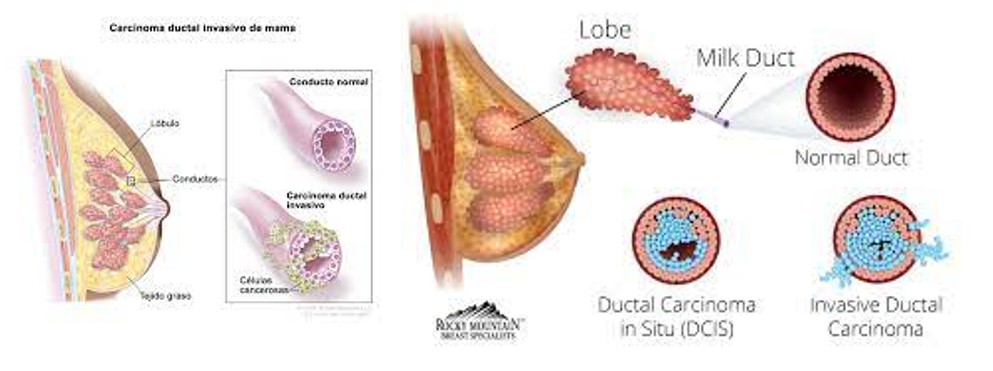

## 1.2 Objetivo de este trabajo

EL objetivo es crear y entrenar un modelo basado en redes neuronales para que pueda detectar y clasificar en base a unas imagenes de entrada si una persona tiene o no IDC (carcinoma ductal invasivo). Para ello usaremos varios modelos: Modelo base SVM, CNN Simple, CNN complejo (basado en arquitectura AlexNet y con algunas modificaciones).  Extraemos las metricas y haremos comparaciones para ver que modelo es el mas robusto y que mejor funciona. 

## 1.3 Conjunto de datos de partida

El conjunto de datos inicial contiene imagenes de pacientes. Cada imagen esta descompuesta en parches, donde para cada paciente tenemos una carpeta "0" con los parches de imagenes que no contienen cancer y otra carpeta denominada "1" para los que si tienen. Y dentro de cada carpeta tenemos las imagenes 

El dataset utilizado es https://academictorrents.com/details/e40bd59ab08861329ce3c418be191651f35e2ffa

La estructura del nombre del archivo de cada imagen se compone por:
     Ejemplo "16551_idx5_x1351_y2501_class1"
*        Codigo del paciente_idx5
*        Posicion x de la imagen.
*        Posicion y de la imagen.
*        Clase (1 si tiene cancer y 0 en caso de no tener cancer)

# 2 ANALISIS EXPLORATORIO DE LOS DATOS (EDA)

## 2.1 Preparación y vistazo a la estructura de datos

En primer lugar importamos todas las librerías necesarias:

In [1]:
!pip install Pillow
!pip install scikit-image
!pip install opencv-python
!pip install matplotlib
!pip install Scikit-learn
!pip install pandas
!pip install seaborn

In [2]:
import os
import numpy as np
import pandas as pd
import re
import glob
import cv2
import skimage
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from skimage import io


In [3]:
#Esta función carga en la variable etiquetas todas las imágenes incluidas en las subcarpetas de la ruta indicada
def cargar_imagenes(ruta):
    dataset=[]
    paciente=0
    dataset=np.array(glob(ruta+'/**/*.png',recursive=True))
    
    patron = r'.\\(\w+)\\(\d+)\\(\d+)\\(\w+)_idx\d+_x(\d+)_y(\d+)_class(\d+)\.png'

        
    datos_imagen=[]
           
    for archivo in dataset:
        match=re.match(patron,archivo)
        if match:
            codigo_paciente=int(match.group(4))
            posicion_x=int(match.group(5))
            posicion_y=int(match.group(6))
            etiqueta=int(match.group(7))                
            datos_imagen.append([codigo_paciente,posicion_x,posicion_y,etiqueta,archivo])     
    
    datos=pd.DataFrame(datos_imagen,columns=['codigo_paciente','x','y','cancer','archivo'])
    return datos

A continuación procedemos a cargar las imágenes y obtener los datos de los nombres de dichas imágenes. Una vez obtenidos todos los datos en un dataframe, creados dos dataframe adicionales donde separamos las imágenes que tienen cáncer de las que no lo tienen.

In [4]:
dataframe=cargar_imagenes('.\IDC_regular_ps50_idx5')
dataset_cancer=np.array(dataframe)
dataframe_sin = dataframe[dataframe['cancer']==0]
dataframe_con = dataframe[dataframe['cancer']==1]

Definimos la función analizar_dataset la cual recibe como parámetro un dataset y nos indica el número de imágenes con cáncer, el número de imágenes sin cáncer y el tamaño de dichas imágenes  

In [5]:
def analizar_dataset(dataset):
    positivo=0
    negativo=0
    j=0
    k=0
    for i in range(len(dataset)):    
        if int(dataset[i][3])==1:            
            positivo=positivo+1            
        else:            
            negativo=negativo+1
    print("Nº total de imágenes",len(dataset))
    print ("Nº positivos",positivo)
    print ("Nº negativos",negativo)
    imagen=io.imread(dataset[0][4])
    print("Tamaño de las imágenes",imagen.shape)

In [6]:
analizar_dataset(dataset_cancer)

Nº total de imágenes 277524
Nº positivos 78786
Nº negativos 198738
Tamaño de las imágenes (50, 50, 3)


A continuación vemos la dimensión del dataframe, mostrándonos 277524 filas con 5 atributos cada una

In [7]:
dataframe.shape

(277524, 5)

Posteriormente mostramos las primeras líneas del dataframe para ver un ejemplo de los datos almacenados.

In [8]:
dataframe.head()

,codigo_paciente,x,y,cancer,archivo
0,10253,1001,1001,0,.\IDC_regular_ps50_idx5\10253\0\10253_idx5_x10...
1,10253,1001,1051,0,.\IDC_regular_ps50_idx5\10253\0\10253_idx5_x10...
2,10253,1001,1101,0,.\IDC_regular_ps50_idx5\10253\0\10253_idx5_x10...
3,10253,1001,1151,0,.\IDC_regular_ps50_idx5\10253\0\10253_idx5_x10...
4,10253,1001,1201,0,.\IDC_regular_ps50_idx5\10253\0\10253_idx5_x10...


Ahora para cada paciente conocemos la ruta de cada parche, así como si contiene IDC o no (el objetivo).

Una vez hemos visto un ejemplo de los datos, pasamos a observar los nombres de los atributos así como el tipo de los mismos

In [9]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277524 entries, 0 to 277523
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   codigo_paciente  277524 non-null  int64 
 1   x                277524 non-null  int64 
 2   y                277524 non-null  int64 
 3   cancer           277524 non-null  int64 
 4   archivo          277524 non-null  object
dtypes: int64(4), object(1)
memory usage: 10.6+ MB


La informacion estadística basica como puede ser el conteo de campos no nulos, la media, valores únicos, etc...

In [10]:
dataframe.describe()

,codigo_paciente,x,y,cancer
count,277524.000000,277524.000000,277524.000000,277524.000000
mean,11811.994757,1620.891433,1207.814005,0.283889
std,2354.814020,813.975056,628.163551,0.450884
min,8863.000000,1.000000,1.000000,0.000000
25%,9322.000000,1001.000000,701.000000,0.000000
50%,12750.000000,1601.000000,1151.000000,0.000000
75%,13458.000000,2201.000000,1651.000000,1.000000
max,16896.000000,4001.000000,2951.000000,1.000000


## 2.1.1 Resumen
      
* Podemos observar que tenemos los datos de 279 pacientes. 
* En total tendremos 277524 parches de imagenes de los pacientes, de los cuales 198.738 (71.63%) no tienen cancer y 78.785 (28.37%) si tienen cancer. 
* El tamaño de los parches de las imagenes es (50,50,3). 50 pixeles por 50 pixeles con 3 canales color RGB.



## 2.2 Analisis Exploratorio

Vamos a generar representaciones gráficas para entender mejor los datos almacenados

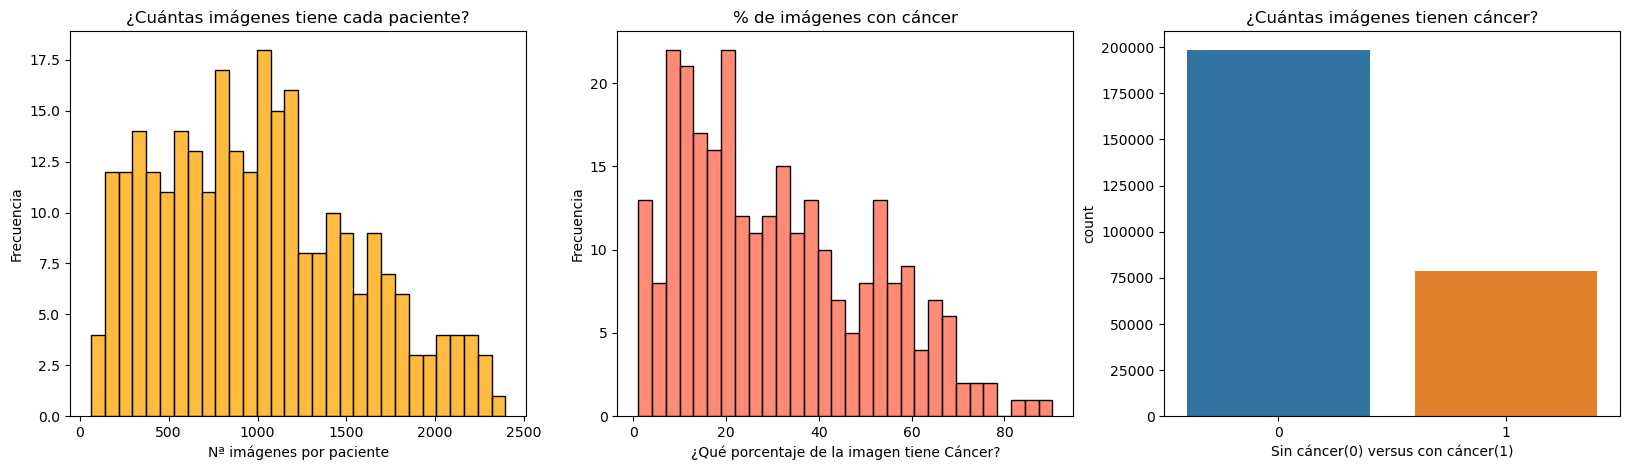

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))



sns.histplot(dataframe.groupby("codigo_paciente").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Nª imágenes por paciente")
ax[0].set_ylabel("Frecuencia")
ax[0].set_title("¿Cuántas imágenes tiene cada paciente?")

sns.histplot((dataframe_con.groupby("codigo_paciente").size()/dataframe.groupby("codigo_paciente").size())*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_xlabel("¿Qué porcentaje de la imagen tiene Cáncer?")
ax[1].set_ylabel("Frecuencia")
ax[1].set_title("% de imágenes con cáncer")

sns.countplot(data=dataframe,x="cancer", ax=ax[2])
ax[2].set_xlabel("Sin cáncer(0) versus con cáncer(1)")
ax[2].set_title("¿Cuántas imágenes tienen cáncer?")

plt.show()



Vamos a mostrar imagenes de casos con IDC positivios y casos negativos a modo de ejemplo. Para ello tenemos separadas las imágenes positivas de las negativas en dos dataset diferentes.

A continuación mostramos algunas imágenes aleatorias de cada grupo. En primer mostramos imágenes sin cáncer.

Imágenes sin cáncer


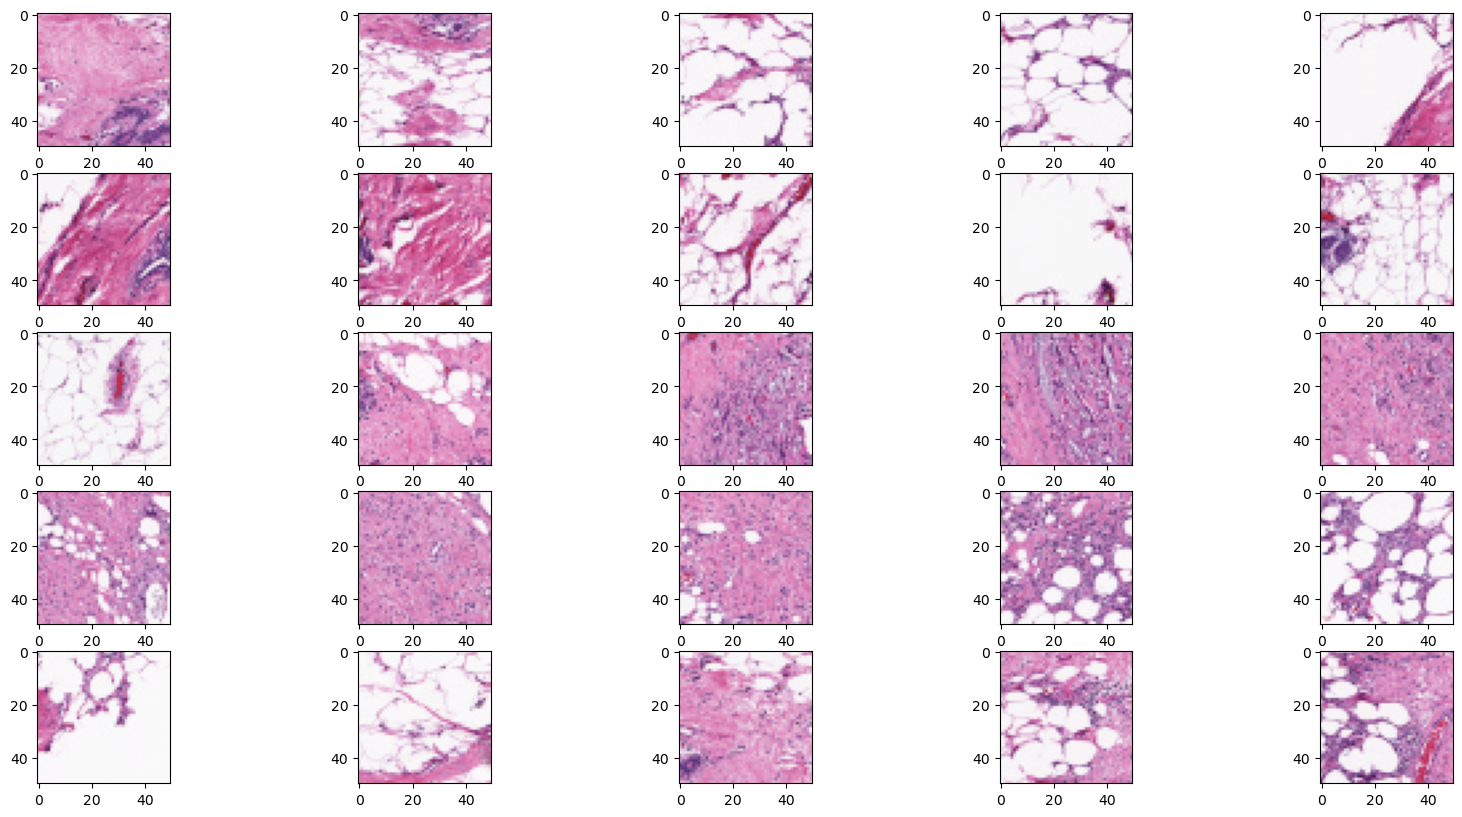

In [12]:
fig_sin, ax_sin = plt.subplots(5,5,figsize=(20,10))

print("Imágenes sin cáncer")
for fila in range(5):
    for columna in range(5):
     imagenes = dataframe_sin.loc[int(fila*5+columna),:]        
     imagen = io.imread(imagenes["archivo"])
     ax_sin[fila,columna].imshow(imagen)
     ax_sin[fila,columna].grid(False)



En segundo mostramos imágenes con cáncer.

Imágenes con cáncer


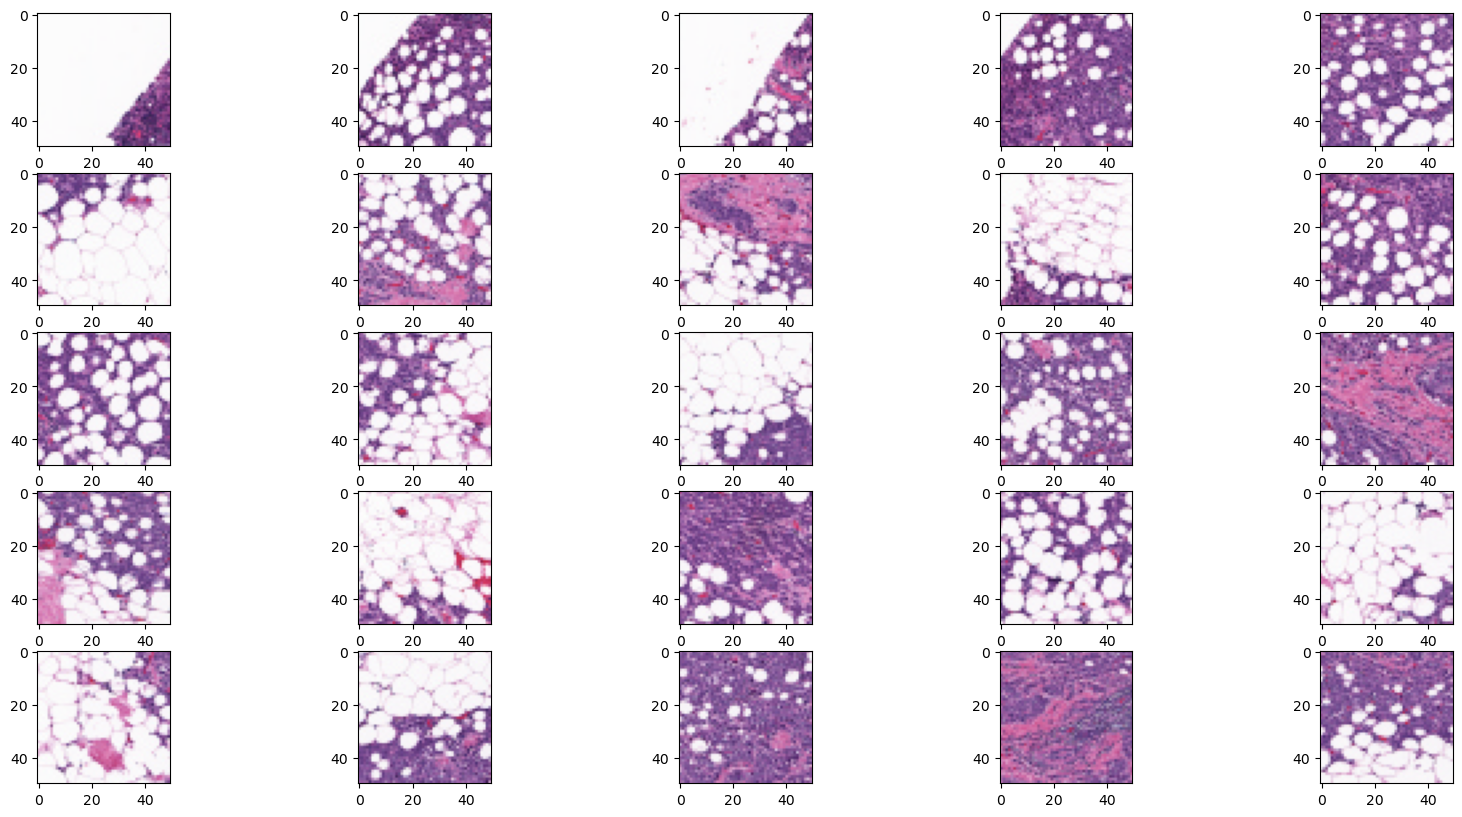

In [13]:
fig_con, ax_con = plt.subplots(5,5,figsize=(20,10))

print("Imágenes con cáncer")
for fila in range(5):
    for columna in range(5):
      imagenes_con=dataframe_con.loc[int(fila*5+columna+479),:]
      imagen_con = io.imread(imagenes_con["archivo"])
      ax_con[fila,columna].imshow(imagen_con)
      ax_con[fila,columna].grid(False)


## Insights

* En el primer grafico del analisis exploratorio denominado "¿Cuantas imagenes tiene cada paciente?"podemos observar como el número de parches de imagen por paciente varía mucho y que no es uniforme. 
*  En el segundo grafico del analisis exploratorio denominado "% de imagenes con cancer"podemos observar como algunos pacientes tienen más del 80 % de parches que muestran IDC con cancer.
* En el tercer grafico del analisis exploratorio denominado "¿Cuantas imagenes tienen cancer?" podemos observar que las clases de IDC con cancer versus IDC sin cancer están desequilibradas.Por lo general afecta a los algoritmos en su proceso de generalización de la información y perjudicando a las clases minoritarias. Si no tomamos ninguna estrategia para tratar este desbalanceo es probable que tengamos un alto valor de precisión en la clase Mayoritaria y un bajo recall en la clase Minoritaria. Entre todas las estrategias para manejar datos desbalanceados, mas adelante optaremos por el ajuste de parametros del modelo, y por ejemplo podríamos ajustar la métrica de Loss para que penalice a las clases mayoritarias.
* El numero de pacientes es pequeño en comparación con el número esperado de pacientes que uno quisiera analizar con nuestro algoritmo después de la implementación. En consecuencia, es muy probable que surja overfitting a esta distribución específica de pacientes y debemos tener cuidado con el rendimiento de generalización de nuestro modelo.
* Nuestro algoritmo necesita decidir si un parche de imagen contiene IDC o no. En consecuencia, no se debe considerar como entrada para nuestro algoritmo el corte completo del tejido del paciente, sino los parches individuales.
* Para alimentar el algoritmo con parches de imagen, sería bueno almacenar la ruta de cada imagen. De esta manera, podemos cargar lotes de imágenes solo una por una sin almacenar los valores de píxel de todas las imágenes.
* Por ultimo, a golpe de vista parece que los parches de imagenes con cancer se ven mas violetas vs. los que no tienen cancer.  

## FINAL DE LA PROPUESTA PARA EL ANALISIS EXPLORATIO DE LOS DATOS